In [1]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "theano"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
import util
from util import set_trainable

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: TITAN X (Pascal) (CNMeM is enabled with initial size: 90.0% of memory, cuDNN 5105)


In [2]:
bg = util.load_data("bg_sherpa_yj2_pt140.csv")
sig = util.load_data("sig_yzp_g25_m100.csv")

bg = bg.assign(process=0)
sig = sig.assign(process=1)

bg, sig = util.standardize(bg, sig)

In [3]:
train, test = util.mk_train(bg, sig)

feature_set = ['std_ph_e', 'std_ph_pt', 'std_ph_eta', 'std_ph_eta',
               'std_jet_pt', 'std_jet_eta', 'std_jet_phi', 'std_jet_mass',
               'std_tau21', 'std_d2', 'std_c2']

targets = ['is_bg', 'is_sig']

X = train[feature_set].as_matrix()
y = train[targets].as_matrix()
y_reg = train.std_jet_mass.as_matrix()

X_test = test[feature_set].as_matrix()
y_test = test[targets].as_matrix()

In [499]:
class CB(keras.callbacks.Callback):
    def __init__(self, do_auc=False):
        keras.callbacks.Callback.__init__(self)
        self.do_auc = do_auc
        
    def on_train_begin(self, logs={}):
        self.sys_loss = []
        self.sys_vloss = []
        
        self.reg_loss = []
        self.reg_vloss = []
        
        self.cls_loss = []
        self.cls_vloss = []
        self.cls_AUC = []
        
    def on_epoch_begin(self, iepoch, logs={}):
        if (iepoch+1)%10==0:
            print "epoch {}/{}".format(iepoch+1, self.params['nb_epoch'])
        
    def on_epoch_end(self, iepoch, logs={}):
        self.sys_loss.append(logs['loss'])
        self.sys_vloss.append(logs['val_loss'])
        
        self.reg_loss.append(logs['reg_output_loss'])
        self.reg_vloss.append(logs['val_reg_output_loss'])
        
        self.cls_loss.append(logs['cls_output_loss'])
        self.cls_vloss.append(logs['val_cls_output_loss'])
        
        if self.do_auc:
            yhat = model.predict(X_test)[0][:,1]
            roc = util.mk_roc(yhat, test)
            self.cls_AUC.append(util.calc_auc(roc))

In [615]:
lr_classifier = 1e-4
lr_adversary = 1e-1
lambda_adv = 0#100



adv_loss_weight = 1.*lr_adversary / lr_classifier
gradient_reversal_scale = 1.*lambda_adv / adv_loss_weight 

print gradient_reversal_scale
print adv_loss_weight

opt = keras.optimizers.SGD(lr_classifier)

cls_input = layers.Input(shape=(len(feature_set),))
H = layers.Dense(256, activation='tanh')(cls_input)
H = layers.Dense(256, activation='tanh')(H)
H = layers.Dense(256, activation='tanh')(H)
cls_output = layers.Dense(2, activation='softmax', name='cls_output')(H)
cls_model = keras.models.Model(cls_input, cls_output)

H = util.GradientReversalLayer(gradient_reversal_scale)(cls_output)
H = layers.Dense(64, activation='tanh')(H)
H = layers.Dense(64, activation='tanh')(H)
reg_output = layers.Dense(1, activation='linear', name='reg_output')(H)
reg_model = keras.models.Model(cls_input, reg_output)

model = keras.models.Model(cls_input, [cls_output, reg_output])
model.compile(opt, loss=['categorical_crossentropy', 'mse'], loss_weights=[1,adv_loss_weight])
model.summary()

0.0
1000.0
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_92 (InputLayer)            (None, 11)            0                                            
____________________________________________________________________________________________________
dense_230 (Dense)                (None, 256)           3072        input_92[0][0]                   
____________________________________________________________________________________________________
dense_231 (Dense)                (None, 256)           65792       dense_230[0][0]                  
____________________________________________________________________________________________________
dense_232 (Dense)                (None, 256)           65792       dense_231[0][0]                  
________________________________________________________________________________

In [616]:
batch_size = 1024
nb_epoch = 60
verbose = 0

cb = CB(True)

model.fit(X, [y, y_reg], batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=verbose, validation_split=0.2, callbacks=[cb],
          sample_weight=[np.ones(len(X)), train.is_bg.as_matrix()], class_weight=['auto', None])

epoch 10/60
epoch 20/60
epoch 30/60
epoch 40/60
epoch 50/60
epoch 60/60


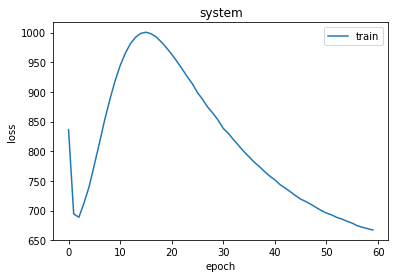

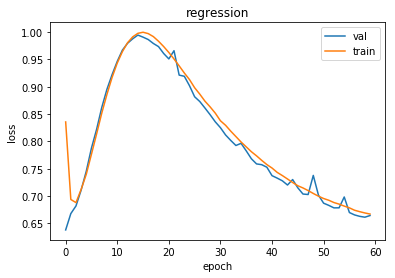

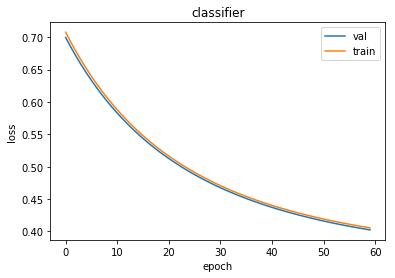

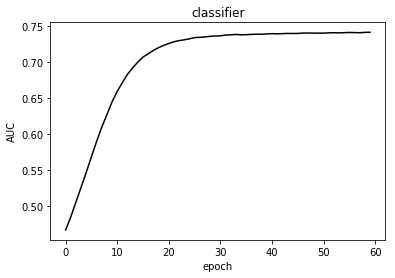

In [617]:
#plt.plot(cb.sys_vloss, label='val')
plt.plot(cb.sys_loss, label='train')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.title('system'); plt.legend();

plt.figure()

plt.plot(cb.reg_vloss, label='val')
plt.plot(cb.reg_loss, label='train')
plt.xlabel('epoch'); plt.ylabel('loss');
plt.title('regression'); plt.legend();

plt.figure()

plt.plot(cb.cls_vloss, label='val')
plt.plot(cb.cls_loss, label='train')
plt.xlabel('epoch'); plt.ylabel('loss');
plt.title('classifier'); plt.legend();

plt.figure()

plt.plot(cb.cls_AUC, color='black')
plt.xlabel('epoch'); plt.ylabel('AUC');
plt.title('classifier');

In [618]:
yhat_cls, yhat_reg = model.predict(X_test)
yhat_cls = yhat_cls[:,1]

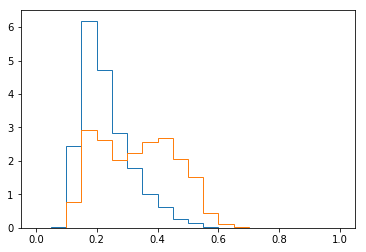

In [619]:
plt.hist(yhat_cls[test.is_bg==1], histtype='step', bins=20, range=(0,1), normed=True)
plt.hist(yhat_cls[test.is_bg==0], histtype='step', bins=20, range=(0,1), normed=True);

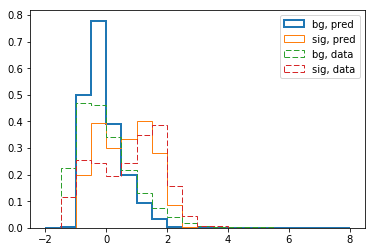

In [620]:
plt.hist(yhat_reg[test.is_bg==1], histtype='step', bins=20, range=(-2,8), lw=2, label='bg, pred', normed=True);
plt.hist(yhat_reg[test.is_bg==0], histtype='step', bins=20, range=(-2,8), label='sig, pred', normed=True);
plt.hist(test[test.is_bg==1].std_jet_mass, histtype='step', bins=20, range=(-2,8),ls='--', label='bg, data', normed=True);
plt.hist(test[test.is_bg==0].std_jet_mass, histtype='step', bins=20, range=(-2,8),ls='--', label='sig, data', normed=True);
plt.legend();

[  50.   60.   70.   80.   90.  100.  110.  120.  130.  140.  150.  160.
  170.  180.  190.]


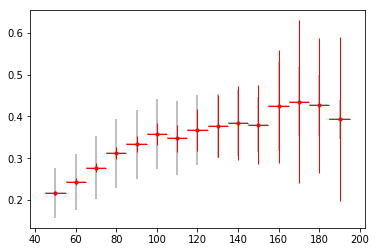

In [621]:
util.plot_profile(yhat_cls, test)